<a href="https://colab.research.google.com/github/Sunkyoung/PyTorch-Study/blob/main/PyTorch_Study_06_GAN(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![picture](https://drive.google.com/uc?id=1vC0N3Obk4HZJk9JOG7fKgYE10YYlCqsg)

# Week 6: Generative adversarial network (GAN) 

- We will cover basic concepts of GAN & implement vanilla GAN \[[Goodfellow et al., NIPS 2014](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)\]
- We will give basic skeletone code which include (1) training structure (2) sample visualization (3) FID evaluation
- You should implement (1) ***generator & discriminator architecture*** (2) ***noise sampling***  (3) ***GAN loss*** 
- Additionally, will give you [DCGAN](https://arxiv.org/abs/1511.06434) (basic GAN architecture) code that you can enjoy by your-self 

If you have any questions, feel free to ask
- For additional questions, send emails to jihoontack@kaist.ac.kr

## Practice Notebook Problem Solution
### **TODO : Fill the answer below Q**

## 0. Preliminary

### 0.1. Prelim step 1: Load packages & GPU setup

In [ ]:
# visualize current GPU usages in your server
!nvidia-smi 

Fri Jan 21 07:48:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# set gpu by number 
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

In [ ]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio #### install with "pip install imageio"
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [ ]:
# Create folders
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')
    
if not os.path.exists('./dataset'):
    os.mkdir('./dataset')
    
if not os.path.exists('./img'):
    os.mkdir('./img')
    
if not os.path.exists('./img/real'):
    os.mkdir('./img/real')

if not os.path.exists('./img/fake'):
    os.mkdir('./img/fake')

### 0.2. Prelim step 2: Define visualization & image saving code

In [ ]:
# visualize the first image from the torch tensor
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [ ]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid 
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('./img/training_progress.gif', training_progress_images)
    return training_progress_images

In [ ]:
# visualize gif file
def vis_gif(training_progress_images):
    fig = plt.figure()
    
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    html = ani.to_html5_video()
    HTML(html)

In [ ]:
# visualize gif file
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()
    
    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [ ]:
def save_image_list(dataset, real):
    if real:
        base_path = './img/real'
    else:
        base_path = './img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)
    
    return base_path

### 0.3. Prelim step 3: Load dataset, define dataloader

![picture](https://drive.google.com/uc?id=1kdig6RLSCvYJNqarbb8gviYsnxZfSkYQ)


In this class we will use **MNIST** (or you can use **Fashion-MNIST**) due to the time constraint :( \
You can practice with CIFAR-10 by your-self since dataset is already implemented inside PyTorch!
- Simply use `dataset=dset.CIFAR10(.)` function in PyTorch.
- If you are using CIFAR dataset, please note that the resolution is different to MNIST and should change model input dimension.

In [ ]:
dataset = dset.MNIST(root="./dataset", download=True,
                                   transform=transforms.Compose([
                                   transforms.ToTensor(),
                ]))
# If you want to download FMNIST use dset.FashionMNIST
# dataset = dset.FashionMNIST(.)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

## 1. Define your generator & discriminator

### 1.1. Define generator module

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Q. Define generator model
            #    Three linear layers and three activation layers
            #    Use ReLU for first two activation, and then use Sigmoid for the last activation
            #    input shape: 100 -> 256 -> 256, output shape : 784
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, input):
        # Q. Forward input to main model and change the output shape if necessary
        # Hint) output shape : (batch_size, 1, 28, 28)
        output = self.main(input)
        output = output.view(-1, 1, 28, 28)

        return output

### 1.2. Define discriminator module

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
        # Q. Define discriminator model
        #    Three linear layers and three activation layers
        #    Use LeakyReLU with negative slope 0.2 for first two activation, and then use Sigmoid for the last activation
        #    input shape: Generator model output -> 256 -> 256, output shape : 1
        # Hint) LeakyReLU : https://pytorch.org/docs/1.9.1/generated/torch.nn.LeakyReLU.html
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        # Q. Forward input to main model and change the input, output shape if necessary
        # Hint) input shape : refer to first forward layer's shape / output shape : (batch_size,)
        input = input.view(-1, 28*28)
        output = self.main(input)
        output = output.squeeze(dim=1)
        
        return output

### 1.3. Upload on GPU, define optimizer

In [ ]:
netG = Generator().cuda()
netD = Discriminator().cuda()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

## 2. Noise sampling

In [ ]:
# Q. Define noise with random numbers from a normal distribution and load to GPU
#    shape : (batch_size, refer to input shape of generator first layer)
# Hint) https://pytorch.org/docs/stable/generated/torch.randn.html
fixed_noise = torch.randn(128, 100).cuda()

## 3. Train GAN

Implement GAN by filling out the following blankes!

In [ ]:
criterion = nn.BCELoss()
n_epoch = 200
training_progress_images_list = []

for epoch in range(n_epoch):
    for i, (data, _) in enumerate(dataloader):
        # Q. Update Discrimator Network. Maximize log(D(x)) + log(1 - D(G(z)))
        #    Fill ???
        #    Ground truth (real) label  : 1
        netD.zero_grad()
        data = data.cuda()
        batch_size = data.size(0)

        label = torch.ones((batch_size,)).cuda()
        output = netD(data)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # Q. Train with generated fake image.  Fill ???
        #    Fake image label : 0
        # Hint) Define noise refer to above fixed_noise
        noise = torch.randn(batch_size, 100).cuda()
        fake = netG(noise)
        label = torch.zeros((batch_size,)).cuda()
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        
        # Q. Define loss of discrimator
        errD = errD_real + errD_fake

        errD.backward()
        optimizerD.step()

        # Q. Update Generator Network : Maximize log(D(G(z)))
        #    Fill ???
        # Hint : Fake labels are real for generator cost
        netG.zero_grad()
        label = torch.ones((batch_size,)).cuda()
        output = netD(fake)
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        errG.backward()
        optimizerG.step()
        
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
              % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    #save the output
    fake = netG(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, fake)  # Save fake image while training!
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

[0/200] Loss_D: 0.0222 Loss_G: 5.5339 D(x): 0.9853 D(G(z)): 0.0065 / 0.0040
[1/200] Loss_D: 0.0062 Loss_G: 6.2665 D(x): 0.9970 D(G(z)): 0.0032 / 0.0019
[2/200] Loss_D: 0.0110 Loss_G: 6.1457 D(x): 0.9950 D(G(z)): 0.0058 / 0.0023
[3/200] Loss_D: 0.0117 Loss_G: 7.5636 D(x): 0.9917 D(G(z)): 0.0014 / 0.0006
[4/200] Loss_D: 0.0012 Loss_G: 8.4435 D(x): 0.9996 D(G(z)): 0.0008 / 0.0006
[5/200] Loss_D: 0.0110 Loss_G: 7.4028 D(x): 0.9991 D(G(z)): 0.0099 / 0.0016
[6/200] Loss_D: 0.0042 Loss_G: 8.2674 D(x): 0.9984 D(G(z)): 0.0025 / 0.0007
[7/200] Loss_D: 0.0278 Loss_G: 6.7228 D(x): 0.9857 D(G(z)): 0.0051 / 0.0020
[8/200] Loss_D: 0.0656 Loss_G: 5.9871 D(x): 0.9800 D(G(z)): 0.0087 / 0.0049
[9/200] Loss_D: 0.0147 Loss_G: 9.3332 D(x): 0.9894 D(G(z)): 0.0007 / 0.0002
[10/200] Loss_D: 0.0369 Loss_G: 5.3454 D(x): 0.9901 D(G(z)): 0.0080 / 0.0136
[11/200] Loss_D: 0.0211 Loss_G: 9.2256 D(x): 0.9979 D(G(z)): 0.0159 / 0.0040
[12/200] Loss_D: 0.0009 Loss_G: 10.1327 D(x): 1.0000 D(G(z)): 0.0009 / 0.0002
[13/200]

## 4. Visualize/Plot your generated samples

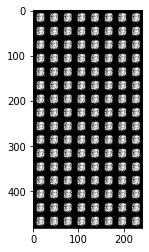

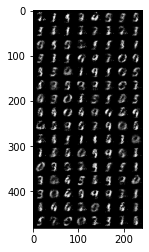

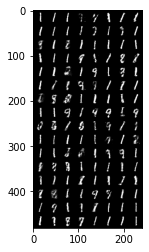

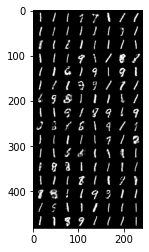

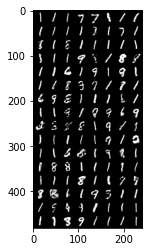

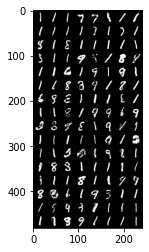

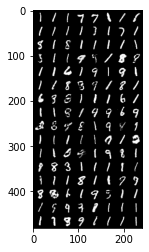

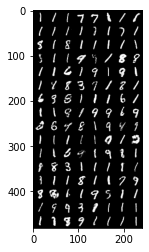

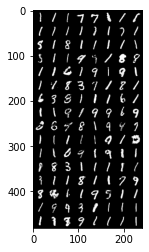

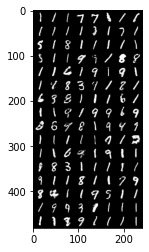

In [ ]:
#vis_gif(training_progress_images_list)
plot_gif(training_progress_images_list)

## 5. Evaluate your model: Fréchet Inception Distance (FID) score

How to evaluate the equality of your generated sample?\
Maybe **training loss...? No!**
Papers have shown that training loss might not be the best metric!

There are many evaluation metric that has been proposed and most famous metric is as follows: [**Inception score**](https://arxiv.org/abs/1606.03498), [**Fréchet Inception Distance**](https://arxiv.org/abs/1706.08500)

In this course, we will handle **Fréchet Inception Distance (FID) score.**

### 5.1. What is FID score?

FID measures the distance between **real dataset** & **fake dataset** in **feature space of Inception** pretrained network.\
From the extracted features of real & fake dataset, we can compute mean & covariance of each features to calculate the **distance between distributions**.
- For more explanation see this [article](https://medium.com/@jonathan_hui/gan-how-to-measure-gan-performance-64b988c47732) or [paper](https://arxiv.org/abs/1706.08500)

For the implementation, we simply use the source code from github: https://github.com/mseitzer/pytorch-fid

Please note that Inception network is **pretrained on ImageNet**, therefore the MNIST FID score might be unrealiable.\

### 5.2. Load FID score function: code is from the github

In [ ]:
# The code is downloaded from github
!git clone https://github.com/mseitzer/pytorch-fid.git
!mv /content/pytorch-fid/src/pytorch_fid/fid_score.py .
!mv /content/pytorch-fid/src/pytorch_fid/inception.py .

fatal: destination path 'pytorch-fid' already exists and is not an empty directory.
mv: cannot stat '/content/pytorch-fid/src/pytorch_fid/fid_score.py': No such file or directory
mv: cannot stat '/content/pytorch-fid/src/pytorch_fid/inception.py': No such file or directory


In [ ]:
from fid_score import calculate_fid_given_paths

### 5.3. Evaluate your model (save samples!!)

The Inception network's input resolution is 224 by 224, we upscale small resolution datasets (e.g., MNSIT, CIFAR) into same resolution.

Please note that, we only save *50 samples in this lecture*, however in practice we use **full test dataset**: [reference](https://arxiv.org/abs/1807.04720)

In [ ]:
test_dataset = dset.MNIST(root="./dataset", download=True, train=False,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                        ]))

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=2)

for i, (data, _) in enumerate(dataloader):
    real_dataset = data
    break
    
noise = torch.randn(50, 100).cuda()
fake_dataset = netG(noise)

In [ ]:
real_image_path_list = save_image_list(real_dataset, True)
fake_image_path_list = save_image_list(fake_dataset, False)

### 5.4 Evaluate FID score

In [ ]:
# calculate_fid_given_paths(paths, batch_size, cuda, dims)
fid_value = calculate_fid_given_paths(paths=[real_image_path_list, fake_image_path_list], 
                                      batch_size=50,
                                      device='cuda',
                                      dims=2048,
                                      num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


In [ ]:
print (f'FID score: {fid_value}')

FID score: 106.86173868574471


## Additional: DCGAN 

A DCGAN is a direct extension of the GAN described above, except that it explicitly uses **convolutional and convolutional-transpose layers** in the discriminator and generator, respectively.

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

There are various modern architectures of GAN e.g., DCGAN, SNGAN, and also training methods e.g., WGAN, gradient penulty

You can try the following architecture to improve the quality of generation!
- **Note that this version is for 64 by 64 resolution**

In [ ]:
nc = 3 # number of channels, RGB
nz = 100 # input noise dimension
ngf = 64 # number of generator filters
ndf = 64 # number of discriminator filters

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Q. Define generator model
            #    Five Convolutional-transpose layers instead of Linear 
            #    First four layers use Batch-normalization layer and ReLU activation
            #    Last layer use Tanh activation only.
            #    Input size
            #    1) Z
            #    2) (ngf*8) x 4 x 4
            #    3) (ngf*4) x 8 x 8
            #    4) (ngf*2) x 16 x 16
            #    5) (ngf) x 32 x 32
            #    Output size : (nc) x 64 x 64
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Q. Define discriminator model
            #    Five Convolutional layers instead of Linear 
            #    Layers except first and last use Batch-normalization
            #    First four layers use LeakyReLU activation and Last layer use Sigmoid activation only.
            #    Input size
            #    1) (nc) x 64 x 64
            #    2) (ngf) x 32 x 32
            #    3) (ndf*2) x 16 x 16
            #    4) (ndf*4) x 8 x 8
            #    5) (ndf*8) x 4 x 4
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

## Reference

PyTorch official DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html \
github 1: https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py \
github 2: https://github.com/mseitzer/pytorch-fid \
FID score: https://github.com/mseitzer/pytorch-fid \
Inception score: https://github.com/sbarratt/inception-score-pytorch